# UFO

<font color='#660066'>
   
### Table of Contents

- [Data](#Data)
    - [Scraping from UFORC](#Scraping-from-UFORC)
    - [Data Format](#data_format)
    - [Cleaing Data](#cleaning_pdata)
- [Basic anlayis](#Basic-Anylsis)
- [Milestone 3](#milestones)

In [1]:
%load_ext autoreload
%autoreload 2
import json
import pandas as pd
from scraping import fetch_shape_urls,  \
                     fetch_all_sighting_urls, \
                     store_to_json, \
                     build_report_dataframe
from postprocessing import get_time_of_occurrence, \
                           to_datetime_add_year, \
                           replace_empty_with_nan, \
                           distribution_histogram 
from plot import post_process, \
                 sightings_per_state_unnormalized 

<font color='#660066'>
   
# Data

## Scraping from UFORC

The National UFO Reporting Center (**NUFORC**) lists reports splitted by the occured date, by posting date, by shape or by location. These sightings has been collected since 1974. NUFORC provides a [Hotline](http://www.nuforc.org/Report.html) or [web formular]() to submit the UFO encounters. These reports are checked for hoax and fake reporst, according to [several reports](https://www.reddit.com/r/UFOs/comments/6h5jfc/nuforc_filters_their_reports_much_better_than/). The sightings also include articles from news papers and historical accounts.

We decided to scrape the data from their web page using the *request* and *beatifulsoup* libraries. 

The first step to fetch all the possible shapes and then we can fetch all the urls from each of the shape. 



In [2]:
all_shapes = fetch_shape_urls()
all_reporting_urls = fetch_all_sighting_urls(all_shapes)

<font color='#660066'>

Let's see how many shapes and reportings there are: 

In [3]:
print("Number of shapes:", len(all_shapes))
print("Nubmer of sighting:", len(all_reporting_urls))

Number of shapes: 31
Nubmer of sighting: 117560


<font color='#660066'>

We don't want to constantly send requests to the server, therefore store the file in urls in a json file. 

In [2]:
file_name = 'full_list_of_urls.json'
store_to_json(all_reporting_urls, file_name)

NameError: name 'all_reporting_urls' is not defined

In [9]:
# import href list of each report
with open(file_name) as train_file:
    href_data = json.load(train_file)
urls_to_read = href_data['url']['0']

sample_report = urls_to_read[:10000]

<font color='#660066'>

Now we are ready to fetch all the reports and convert it to a Pandas Dataframe.

In [10]:
%%time
df_reports = build_report_dataframe(sample_report)

Could not fetch  http://www.nuforc.org/webreports/116/S116180.html
Could not fetch  http://www.nuforc.org/webreports/026/S26853.html
Could not fetch  http://www.nuforc.org/webreports/128/S128991.html
Could not fetch  http://www.nuforc.org/webreports/129/S129006.html
Could not fetch  http://www.nuforc.org/webreports/035/S35193.html
Could not fetch  http://www.nuforc.org/webreports/090/S90490.html
Could not fetch  http://www.nuforc.org/webreports/089/S89220.html
Could not fetch  http://www.nuforc.org/webreports/042/S42582.html
Could not fetch  http://www.nuforc.org/webreports/036/S36881.html

CPU times: user 43.6 s, sys: 6.72 s, total: 50.3 s
Wall time: 1min 34s


str

In [11]:
df_reports.to_json("all_sightings_10k_sample.json")

<font color='#660066'>

The whole scraping process took more than 1 hour. 

In [7]:
df_reports = pd.read_json('all_sightings.json')
df_reports.sample(1).head()

,Duration,Location,Occurred,Posted,Reported,Shape,Summary,url
53655,10 minutes,"Kendall, NY",10/2/2015 19:00 (Entered as : 10/02/15 19:00),11/6/2015,11/2/2015 8:41:53 PM 20:41,Light,"['A friend and I were driving, when we both no...",http://www.nuforc.org/webreports/123/S123329.html


<font color='#660066'>
   
The data contains the following columns: 

- Occurred
- Reported
- Posted
- Location
- Shape
- Duration
- Summary

The following sections analyze these data throughly. 

<font color='#660066'>
    
## Cleaning data

Let's see how many are not fetched:

In [8]:
not_found_reports = df_reports[pd.isnull(df_reports.Summary)]
print("Not found reports", not_found_reports.count()['url'])

Not found reports 105


<font color='#660066'>

These are reports which were not fetched correctly, we have to investigate further why these are missing. 

In [9]:
df_every_thing = df_reports.rename(index=str, columns={'Occurred ':'Occurred'})

<font color='#660066'>

In our dataset we noticed there are several emtpy strings. <br/>
We decided exchange these empty strings with NaN for easier parsing. 

In [10]:
# already done in post_process
df_every_thing = replace_empty_with_nan(df_every_thing, 'Occurred')

Occurred feature has 156 missing values


<font color='#660066'>

The function below does raw post processing on the scraped data such as cleaning whitespace, renaming the columns, ordering the columns and applies filters so that we only retrieve the desired data wich contains summary data and sufficient information for the states.


In [324]:
df_ufo_reports = post_process(df_reports)

splitting Location..


/Users/josefweber/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/Users/josefweber/Documents/UNI/WS-18/Applied Data Science/project/ada_project/plot.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_ufo_reports['Location'] = df_ufo_reports['Location'].apply(lambda x: x.strip()) # 333ys


cleaning Location..
cleaning State..
cleaning Reported
cleaning Posted..
cleaning Summary..
re-ordering columns..
done


<font color='#660066'>

### Occurred / Reported / Posted

In [12]:
converted = get_time_of_occurrence(df_every_thing)

/Users/josefweber/Documents/UNI/WS-18/Applied Data Science/project/ada_project/postprocessing.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_time_occur_report.year[i] = df_time_occur_report.Occurred[i].year


<font color='#660066'>
Fro the plot above, we use a subsample of 1000 elements. 

To check the distribution of the occurance, wea are plotting the year at which the occurance has been noticed. <br />
The first occurance time is noted as 1400 AD, as a reference to a painting with a descriptive drawing of a plausible UFO.

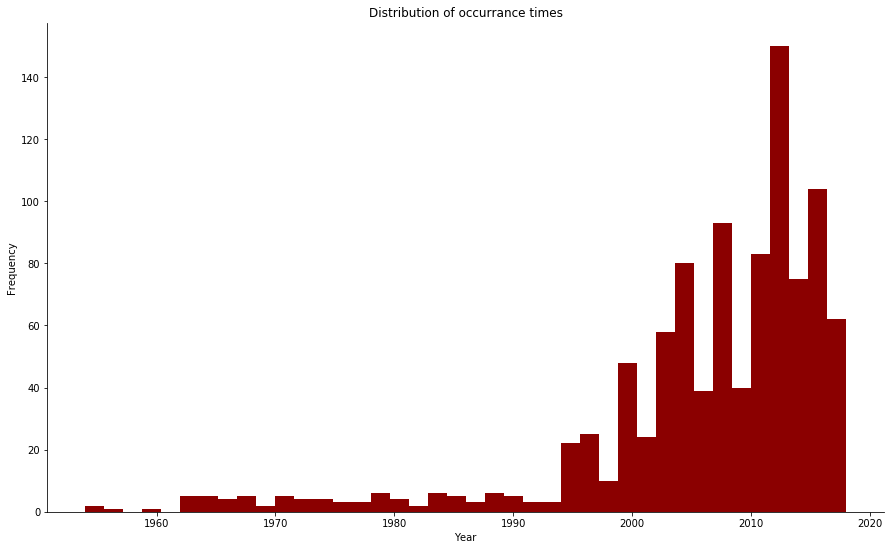

In [38]:
distribution_histogram(converted, 'year')

<font color='#660066'>
    
### Location

<font color='#660066'>

As most of the reportings are from the US, we are showing the distribution of reports from the different states. <br />
The data is not normalized at the moment.

In [305]:
df_every_thing = replace_empty_with_nan(df_every_thing, 'Location')

Location feature has 106 missing values


In [306]:
sightings_per_state_unnormalized(df_ufo_reports)

<font color='#660066'>

### Shape

<font color='#660066'>

The shapes feature consist of 31 different shapes, with the most populated being a 'light source'.

In [46]:
df_every_thing = replace_empty_with_nan(df_every_thing, 'Shape')

Shape feature has 3894 missing values


<font color='#660066'>
    
### Duration

<font color='#660066'>

The duration is a user created data format, with lots of different formats, thus the cleaning and parsing of this data will take a large effort.

In [45]:
df_every_thing = replace_empty_with_nan(df_every_thing, 'Duration')

Duration feature has 4121 missing values


<font color='#660066'>

### Summary

<font color='#660066'>

User made input as the summary about the witnessed UFO sighting of varying length. 

In [47]:
df_every_thing = replace_empty_with_nan(df_every_thing, 'Shape')

Shape feature has 3894 missing values


<font color='#660066'>
   

## Milestone 3

- Analyze what shapes are associated with what feelings? 
- Analyze what shapes are consistently reported at same locations?

- Sentiment Analysis for summary text
    - start with vizualization of text
    ([inspiration](https://www.jasondavies.com/wordtree/?source=obama.inauguration.2013.txt&prefix=we%20must%20act))
- Correlation of weather and reports
- Analyze madar sensor data (also in correlation with weather)
- Create report results plots (webpage)


- dive into sentiment analysis
    - which questtions do we come up with?
    - 
- analyze madar posts
    - occurence
    - meaningfulness
    - how dow we weight those reports?


In [325]:
#todo joe
# split nuforc notes into seperate col

#filter for photos
# weather data - look first by time and season


In [493]:
df_ufo_reports.shape

(117310, 9)

In [561]:
df_split_sum = df_ufo_reports
regex = r"\(\(NUFORC Note.*\)\)"

# filter reports that have any ((NUFORC)) content in summary
filter_has_NUFORC_note = df_split_sum["Summary"].str.contains(regex)
df_split_sum = df_split_sum[filter_has_NUFORC_note]
df_split_sum.shape

(38848, 9)

In [573]:
import re

def single_extract(summary):
    print(summary+ "\n")
    print("----")
    matches = re.finditer(regex, summary, re.MULTILINE)

    for matchNum, match in enumerate(matches):
        matchNum = matchNum + 1

        print("Match {matchNum} was found at {start}-{end}: {match}".format(matchNum = matchNum, start = match.start(), end = match.end(), match = match.group()))

        for groupNum in range(0, len(match.groups())):
            groupNum = groupNum + 1

            print("Group {groupNum} found at {start}-{end}: {group}".format(groupNum = groupNum, start = match.start(groupNum), end = match.end(groupNum), group = match.group(groupNum)))


# split nuforc notes
def split_nuforc_notes_from_summary(df):
    df = df.iloc[0:1,:]
    
    # select summary not null - there should not be any but just to make sure
    filter_nan_summary = pd.isnull(df["Summary"])
    df = df[~filter_nan_summary]
    print(df.shape)
    
    cop_sum = df["Summary"].copy()
    
    for i in cop_sum:
        single_extract(i)
        

split_nuforc_notes_from_summary(df_split_sum)

df_split_sum.head()

(1, 9)
Blinking white light that moved every few seconds when not blinking.  Brighter blinks of white and then went away.  Was moving.', '((NUFORC Note:  We have attempted to contact the witness, who does not indicate a time and date for the sighting.  We have assigned an arbitrary time and date.  PD))', '((NUFORC Note:  Source of report indicates that the date of the sighting is approximate.  PD))

----
Match 1 was found at 131-394: ((NUFORC Note:  We have attempted to contact the witness, who does not indicate a time and date for the sighting.  We have assigned an arbitrary time and date.  PD))', '((NUFORC Note:  Source of report indicates that the date of the sighting is approximate.  PD))


,Duration,Location,State,Occurred,Posted,Reported,Shape,Summary,url
0,10 minutes,Lutz,FL,10/30/2018 23:30,11/9/2018,10/30/2018 8:54:06 PM 20:54,,Blinking white light that moved every few seco...,http://www.nuforc.org/webreports/143/S143627.html
1000,4-5 minutes,Bridgewater,NJ,11/23/2011 00:45 (Entered as : 11/23/11 00:45),6/5/2012,6/5/2012 12:37:48 PM 12:37,,EXPLAINED: Bright lights in Somerset county NJ...,http://www.nuforc.org/webreports/089/S89377.html
100003,:60,Fort Mill,SC,12/16/2014 17:00 (Entered as : 12/16/14 17:00),12/18/2014,12/16/2014 7:01:22 PM 19:01,Triangle,Triangular craft with lights are corners with ...,http://www.nuforc.org/webreports/116/S116060.html
100008,30 seconds,Thornton,CO,12/13/2014 21:00 (Entered as : 21:00),12/18/2014,12/14/2014 6:43:53 AM 06:43,Triangle,"fast silent low flying objects', 'I was watchi...",http://www.nuforc.org/webreports/116/S116014.html
100010,5 minutes,North Wales,PA,12/12/2014 17:30 (Entered as : 12/12/14 17:30),12/18/2014,12/12/2014 2:57:15 PM 14:57,Triangle,"I heard an extremely loud noise outside, and w...",http://www.nuforc.org/webreports/115/S115941.html


## NUFORC note appears at beginning of summary

In [500]:
# NUFORC appear at beginning of summary

df_stord = df_ufo_reports.copy()
filter_begin_note = df_stord['Summary'].str.count("^(\(\(NUFORC)")

df_stord['Occurance'] = filter_begin_note
m = df_stord.groupby('Occurance')['url'].count()
df_stord[df_stord.Occurance == 1]



,Duration,Location,State,Occurred,Posted,Reported,Shape,Summary,url,Occurance
100586,5 minutes,Seattle,WA,2/26/2014 13:00 (Entered as : 02/26/14 13:00),2/27/2014,2/27/2014 9:28:46 AM 09:28,Triangle,((NUFORC Note: Witness provides no informatio...,http://www.nuforc.org/webreports/107/S107500.html,1
100674,20 minutes,Lewisburg,WV,1/6/2014 19:00 (Entered as : 1/6/14 19:00),1/10/2014,1/8/2014 5:28:49 AM 05:28,Triangle,((NUFORC Note: Witness provides no informatio...,http://www.nuforc.org/webreports/106/S106122.html,1
100778,10:00,Sylvan Lake,MI,11/10/2013 19:00 (Entered as : 11/10/13 19:00),11/20/2013,11/11/2013 5:10:52 PM 17:10,Triangle,((NUFORC Note: No information provided by wit...,http://www.nuforc.org/webreports/104/S104353.html,1
10093,OVER CRISSTOWN MALL,Phoenix,AZ,10/15/2000 16:30 (Entered as : 11/15/00 4:30...,2/5/2003,4/22/2001 13:05,Cigar,((NUFORC Note: Discrepancy in date. Report s...,http://www.nuforc.org/webreports/017/S17360.html,1
100941,Unk,North East,MD,8/23/2013 21:45 (Entered as : 08/23/2013 21:45),8/30/2013,8/29/2013 5:10:55 AM 05:10,Triangle,((NUFORC Note: Witness elects to remain total...,http://www.nuforc.org/webreports/101/S101667.html,1
101416,20 minutes,Salt Lake City,UT,11/5/2012 06:45 (Entered as : 11/05/12 6:45),11/19/2012,11/5/2012 6:53:39 PM 18:53,Triangle,((NUFORC Note: Witness provides no informatio...,http://www.nuforc.org/webreports/094/S94156.html,1
10156,20 seconds,Kent,WA,2/2/2000 20:00 (Entered as : 02/02/00 8:00 PM),2/11/2003,2/2/2000 03:28,Cigar,((NUFORC Note: We believe the aircraft were m...,http://www.nuforc.org/webreports/011/S11855.html,1
10179,8.5 min,Keasbey {Woodbridge},NJ,11/11/1999 16:50 (Entered as : 11/11/1999 1650),3/21/2003,12/10/1999 19:53,Cigar,((NUFORC Note: The witness was kind enough to...,http://www.nuforc.org/webreports/011/S11375.html,1
10223,10 minutes,Wachapreague,VA,7/4/1999 23:59 (Entered as : 07/04/99 2400),3/21/2003,7/4/1999 03:42,Cigar,((NUFORC Note: The time is compatible with th...,http://www.nuforc.org/webreports/008/S08256.html,1
10224,10 sec,Mount Pleasant,SC,7/4/1999 23:00 (Entered as : 07/04/99 23:00est),3/4/2003,7/6/1999 00:13,Cigar,((NUFORC Note: The time indicated may be some...,http://www.nuforc.org/webreports/008/S08268.html,1


In [499]:
df_stord = df_stord[filter_begin_note < 1]
df_stord.shape

(116715, 10)

## Split NUFORC note into two df

In [432]:
# split nuforc notes
def split_nuforc_notes_from_summary(df):
    # limit for production
    df = df.iloc[0:50000,:]
    
    # select summary not null
    filter_nan_summary = pd.isnull(df["Summary"])
    df = df[~filter_nan_summary]
    
    # select summary contain NUFORC
    df = df[df['Summary'].str.contains('\(\(NUFORC ')]
    
    # using partition to split after first NUFORC
    splt_ = df['Summary'].str.partition('((NUFORC ', expand=True)
    splt_[2] = splt_[1]+splt_[2]
    splt_ = splt_.drop(columns=1)
    df[['Summary',"NF_notes"]] = splt_

    return df

  
split_ = split_nuforc_notes_from_summary(df_ufo_reports)
split_.head()

,Duration,Location,State,Occurred,Posted,Reported,Shape,Summary,url,NF_notes
0,10 minutes,Lutz,FL,10/30/2018 23:30,11/9/2018,10/30/2018 8:54:06 PM 20:54,,Blinking white light that moved every few seco...,http://www.nuforc.org/webreports/143/S143627.html,((NUFORC Note: We have attempted to contact t...
1000,4-5 minutes,Bridgewater,NJ,11/23/2011 00:45 (Entered as : 11/23/11 00:45),6/5/2012,6/5/2012 12:37:48 PM 12:37,,EXPLAINED: Bright lights in Somerset county NJ...,http://www.nuforc.org/webreports/089/S89377.html,((NUFORC Note: Witness elects to remain total...
100003,:60,Fort Mill,SC,12/16/2014 17:00 (Entered as : 12/16/14 17:00),12/18/2014,12/16/2014 7:01:22 PM 19:01,Triangle,Triangular craft with lights are corners with ...,http://www.nuforc.org/webreports/116/S116060.html,((NUFORC Note: Witness elects to remain total...
100008,30 seconds,Thornton,CO,12/13/2014 21:00 (Entered as : 21:00),12/18/2014,12/14/2014 6:43:53 AM 06:43,Triangle,"fast silent low flying objects', 'I was watchi...",http://www.nuforc.org/webreports/116/S116014.html,"((NUFORC Note: Possible hoax, but we cannot b..."
100010,5 minutes,North Wales,PA,12/12/2014 17:30 (Entered as : 12/12/14 17:30),12/18/2014,12/12/2014 2:57:15 PM 14:57,Triangle,"I heard an extremely loud noise outside, and w...",http://www.nuforc.org/webreports/115/S115941.html,((NUFORC Note: We spoke via telephone with th...


In [458]:
df_stord['Summary']

0         Blinking white light that moved every few seco...
1000      EXPLAINED: Bright lights in Somerset county NJ...
100003    Triangular craft with lights are corners with ...
100008    fast silent low flying objects', 'I was watchi...
100010    I heard an extremely loud noise outside, and w...
100011    Strange glowing object seen in the sky, moving...
100020    Has anyone else noticed the increased military...
100024    Bright red lights flashing look like lights in...
100030    triangular light pattern.  low..silent. flying...
100031    Giant levitating triangle followed our car wit...
100034    Red lights form a triangle', 'Saw 3 balls of o...
100035    Staring up at the stars.  Saw a black triangle...
100036    a triangular object with 5 bright lights.', "I...
100037    V shaped lights over Fairfield & Hamilton Ohio...
100038    It was big, quiet and triangular.', 'On Friday...
100047    3 Black Triangular Objects flying silently ove...
100050    The UFO looked BIG.', 'I had s

In [459]:
df_stord = split_.copy()

# '^\(\(NUFORC '
df_stord['Occ'] = df_stord['Summary'].str.count("^(\(\(NUFORC)")
m = df_stord.groupby('Occ')['url'].count()
m

Occ
0    17437
Name: url, dtype: int64

In [456]:
df_stord[df_stord.Occ == 1]

,Duration,Location,State,Occurred,Posted,Reported,Shape,Summary,url,NF_notes,Occ
0,10 minutes,Lutz,FL,10/30/2018 23:30,11/9/2018,10/30/2018 8:54:06 PM 20:54,,Blinking white light that moved every few seco...,http://www.nuforc.org/webreports/143/S143627.html,((NUFORC Note: We have attempted to contact t...,1
1000,4-5 minutes,Bridgewater,NJ,11/23/2011 00:45 (Entered as : 11/23/11 00:45),6/5/2012,6/5/2012 12:37:48 PM 12:37,,EXPLAINED: Bright lights in Somerset county NJ...,http://www.nuforc.org/webreports/089/S89377.html,((NUFORC Note: Witness elects to remain total...,1
100003,:60,Fort Mill,SC,12/16/2014 17:00 (Entered as : 12/16/14 17:00),12/18/2014,12/16/2014 7:01:22 PM 19:01,Triangle,Triangular craft with lights are corners with ...,http://www.nuforc.org/webreports/116/S116060.html,((NUFORC Note: Witness elects to remain total...,1
100008,30 seconds,Thornton,CO,12/13/2014 21:00 (Entered as : 21:00),12/18/2014,12/14/2014 6:43:53 AM 06:43,Triangle,"fast silent low flying objects', 'I was watchi...",http://www.nuforc.org/webreports/116/S116014.html,"((NUFORC Note: Possible hoax, but we cannot b...",1
100010,5 minutes,North Wales,PA,12/12/2014 17:30 (Entered as : 12/12/14 17:30),12/18/2014,12/12/2014 2:57:15 PM 14:57,Triangle,"I heard an extremely loud noise outside, and w...",http://www.nuforc.org/webreports/115/S115941.html,((NUFORC Note: We spoke via telephone with th...,1
100011,3-5 minutes,Westland,MI,12/10/2014 21:00 (Entered as : 12-10-14 21:00),12/18/2014,12/13/2014 4:52:59 PM 16:52,Triangle,"Strange glowing object seen in the sky, moving...",http://www.nuforc.org/webreports/116/S116035.html,((NUFORC Note: Witness elects to remain total...,1
100020,5 minutes,Apache Junction,AZ,12/6/2014 12:00 (Entered as : 12/6/14 12:00),12/12/2014,12/6/2014 12:44:18 PM 12:44,Triangle,Has anyone else noticed the increased military...,http://www.nuforc.org/webreports/115/S115847.html,((NUFORC Note: Witness elects to remain total...,1
100024,45 minutes,Tinley Park,IL,12/3/2014 18:00 (Entered as : 12/3/2014 18:00),12/5/2014,12/3/2014 5:09:30 PM 17:09,Triangle,Bright red lights flashing look like lights in...,http://www.nuforc.org/webreports/115/S115805.html,((NUFORC Note: Witness elects to remain total...,1
100030,2-5 min,Lincolnton,NC,11/26/2014 19:00 (Entered as : 11/26/14 19:00),11/26/2014,11/26/2014 6:43:07 PM 18:43,Triangle,triangular light pattern. low..silent. flying...,http://www.nuforc.org/webreports/115/S115636.html,((NUFORC Note: Witness elects to remain total...,1
100031,2 hours,Oak Hill,WV,11/25/2014 18:30 (Entered as : 11/25/14 18:30),11/26/2014,11/26/2014 9:40:37 AM 09:40,Triangle,Giant levitating triangle followed our car wit...,http://www.nuforc.org/webreports/115/S115633.html,((NUFORC Note: We spoke via telephone with th...,1


In [18]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from tqdm import tnrange, tqdm_notebook
from multiprocessing import Pool

def get_single_report(ufo_sightings):
    d = {}
    td_list=ufo_sightings.findAll("td")

    # first td
    row_ = td_list[0].findAll(text=True)
    for item in row_:            
        splitvals = item.split(':', 1)
        if len(splitvals) == 2:
            d[splitvals[0]] = splitvals[1]
    
    # second td
    row_ = td_list[1].text
    d["Summary"] = row_
    return d

def request_one_report(each_url):
    #progress.update(1)
    #pbar.update(1)
    sighting_url = url + each_url
    r = requests.get(sighting_url)
    soup = BeautifulSoup(r.text, 'html.parser')
    ufo_report = soup.find('tbody')
    try:
        dict_data_single_report = get_single_report(ufo_report)
        dict_data_single_report["url"] = sighting_url
        return dict_data_single_report
    except:
        print("Could not fetch ", sighting_url)
        return {"url": sighting_url}


# return dataframe of dictionaries of reports
def build_report_dataframe(random_urls):
    
    df_reports_ = pd.DataFrame()
    
    with Pool(500) as pool:
        #result = pool.imap(request_one_report, random_urls)
        for each in tqdm_notebook(pool.imap(request_one_report, random_urls), total=len(random_urls)):
            df_reports_ = df_reports_.append(each, ignore_index=True)
            #print(each)
        #print(result)
    return df_reports_

In [21]:
url = 'http://www.nuforc.org/webreports/'


for i in range(35,45):
    print(i)
    print(request_one_report(urls_to_read[i]))

35
{'Occurred ': ' 10/9/2018 17:48  (Entered as : 10/09/18 17:48)', 'Reported': ' 10/10/2018 7:19:39 AM 07:19', 'Posted': ' 10/12/2018', 'Location': ' Newburgh, IN', 'Shape': ' ', 'Duration': '', 'Summary': 'MADAR Node 06', 'url': 'http://www.nuforc.org/webreports/143/S143449.html'}
36
{'Occurred ': ' 10/7/2018 19:30  (Entered as : 10/718 7:30)', 'Reported': ' 10/7/2018 7:50:17 PM 19:50', 'Posted': ' 10/12/2018', 'Location': ' Cathedral City, CA', 'Shape': ' ', 'Duration': '5 minutes', 'Summary': "strange light with arck-like light lighting up sky, stayed stationary for approx 4/5 min then seem to fall slowly out of sight...  not a spot light... didn't seem like helicopter... never seen anything like it.((NUFORC Note:  Witness elects to remain totally anonymous; provides no contact information.  PD))", 'url': 'http://www.nuforc.org/webreports/143/S143414.html'}
37
{'Occurred ': ' 10/7/2018 19:26  (Entered as : 10/07/2018 7:26pm)', 'Reported': ' 10/9/2018 9:54:58 AM 09:54', 'Posted': ' 